# Classifiers for all targets
Let's train classifiers for all target for different molecular represenatations and compare results. The next step will involve the optimization of hyperparameters for each classifier. `mlflow` will be used for experiment management.<br>

To launch the mlflow server run:
```bash
cd mlflow
mlflow ui --backend-store-uri sqlite:///mlflow.db
```

In [22]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

import polars as pl
from pathlib import Path
import random
import pickle
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd

# add parent directory to path
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from metrics import ClassificationMetrics
from tools import expand_array_column, train_classifier

In [23]:
import mlflow
mlflow.set_tracking_uri("sqlite:///../mlflow/mlflow.db")
mlflow.set_experiment("mol-reprs-benchmark")

<Experiment: artifact_location='/home/anton/Projects/PythonProjects/mol-reprs-benchmark/nbs/mlruns/1', creation_time=1718392699838, experiment_id='1', last_update_time=1718392699838, lifecycle_stage='active', name='mol-reprs-benchmark', tags={}>

In [3]:
path_parquet = Path("../data/2023_09_12_papyrus1k_dataset_more_params_STD_MFP_lessColumns.parquet")
assert path_parquet.exists()

Load precomputed Morgan fingerprints:

In [4]:
path_fps = Path("../out/fingerprints_dicts/d_morgan.pkl")
assert path_fps.exists()

with open(path_fps, "rb") as f:
    d_morgan = pickle.load(f)

Load data and train classifier:

In [5]:
df = pl.read_parquet(path_parquet)

In [6]:
# select randomly 5 targets
# random_targets = ['O94806_WT', 'P48729_WT', 'P80457_WT', 'Q16665_WT', 'P53667_WT']

# for target_id in tqdm(random_targets):
for target_id in tqdm(df["target_id"].unique().to_list()):

    with mlflow.start_run():

        mlflow.set_tag("model_type", "random_forest")
        mlflow.set_tag("dataset", "Papyrus1K")

        mlflow.log_param("target_id", target_id)

        df_target = df.filter(pl.col("target_id") == target_id)
        df_target = df_target.drop(["target_id", "STD_SELFIES"])

        df_target = df_target.with_columns(
            morgan_fp = pl.col("STD_SMILES").map_elements(lambda x: d_morgan[x])
        )

        df_target = expand_array_column(df_target, "morgan_fp", 2048)

        # Define the model
        n_estimators = 1000
        random_state = 42
        model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("random_state", random_state)

        metrics = train_classifier(model, df_target, target_id)
        mlflow.log_metric("mcc_train", metrics.mcc_train)
        mlflow.log_metric("mcc_val", metrics.mcc_val)
        mlflow.log_metric("mcc_test", metrics.mcc_test)

  0%|          | 0/280 [00:00<?, ?it/s]

Extract metrics from `mlflow` and visualize them. This allows not create additional data structure to store metrics.

In [24]:
# all_runs = mlflow.search_runs(search_all_experiments=True)
all_runs = mlflow.search_runs(experiment_ids=[1], order_by=["metrics.mcc_test DESC"])

In [25]:
all_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mcc_train,metrics.mcc_test,metrics.mcc_val,params.target_id,params.random_state,params.n_estimators,tags.model_type,tags.dataset,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type
0,69bf217ca52e4aee895fa3dcc2684da4,1,FINISHED,/home/anton/Projects/PythonProjects/mol-reprs-...,2024-06-14 20:16:05.818000+00:00,2024-06-14 20:16:10.314000+00:00,1.000000,0.941523,0.858315,P55055_WT,42,1000,random_forest,Papyrus1K,anton,enchanting-rook-467,/home/anton/.pyenv/versions/mambaforge/envs/be...,LOCAL
1,3a49c95c1c7348af98d8cd46310f1186,1,FINISHED,/home/anton/Projects/PythonProjects/mol-reprs-...,2024-06-14 20:01:42.711000+00:00,2024-06-14 20:01:45.552000+00:00,0.997380,0.918401,0.860753,P80457_WT,42,1000,random_forest,Papyrus1K,anton,amusing-kite-826,/home/anton/.pyenv/versions/mambaforge/envs/be...,LOCAL
2,13ce1d7702174863a07a15b7fcb78880,1,FINISHED,/home/anton/Projects/PythonProjects/mol-reprs-...,2024-06-14 19:42:55.613000+00:00,2024-06-14 19:43:07.944000+00:00,1.000000,0.880540,0.811512,P11362_WT,42,1000,random_forest,Papyrus1K,anton,sneaky-cod-350,/home/anton/.pyenv/versions/mambaforge/envs/be...,LOCAL
3,297f5161208a43128051862c4077dffa,1,FINISHED,/home/anton/Projects/PythonProjects/mol-reprs-...,2024-06-14 20:32:43.745000+00:00,2024-06-14 20:32:49.972000+00:00,0.994637,0.870794,0.853549,Q9UM73_WT,42,1000,random_forest,Papyrus1K,anton,mysterious-zebra-523,/home/anton/.pyenv/versions/mambaforge/envs/be...,LOCAL
4,08a00aa7746942ee99d7594916d98275,1,FINISHED,/home/anton/Projects/PythonProjects/mol-reprs-...,2024-06-14 20:09:21.081000+00:00,2024-06-14 20:09:27.387000+00:00,1.000000,0.868046,0.809424,P22607_WT,42,1000,random_forest,Papyrus1K,anton,thoughtful-ant-364,/home/anton/.pyenv/versions/mambaforge/envs/be...,LOCAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,31f384f057114bf98ebd7b5dcae6fce0,1,FINISHED,/home/anton/Projects/PythonProjects/mol-reprs-...,2024-06-14 20:28:12.377000+00:00,2024-06-14 20:29:05.100000+00:00,1.000000,-0.012964,-0.032170,Q9Y468_WT,42,1000,random_forest,Papyrus1K,anton,zealous-crow-322,/home/anton/.pyenv/versions/mambaforge/envs/be...,LOCAL
276,2eb3b52466db47f28fc5f3f3d8571cb5,1,FINISHED,/home/anton/Projects/PythonProjects/mol-reprs-...,2024-06-14 20:16:10.319000+00:00,2024-06-14 20:16:16.694000+00:00,1.000000,-0.013206,0.000000,O97447_WT,42,1000,random_forest,Papyrus1K,anton,fearless-ant-578,/home/anton/.pyenv/versions/mambaforge/envs/be...,LOCAL
277,343c1a307dc7479baf6ea3936a55c1c1,1,FINISHED,/home/anton/Projects/PythonProjects/mol-reprs-...,2024-06-14 20:30:56.394000+00:00,2024-06-14 20:31:38.575000+00:00,1.000000,-0.014511,-0.017982,P63092_WT,42,1000,random_forest,Papyrus1K,anton,ambitious-boar-494,/home/anton/.pyenv/versions/mambaforge/envs/be...,LOCAL
278,be90919579ad4cbf8597a7f57ffe3ca1,1,FINISHED,/home/anton/Projects/PythonProjects/mol-reprs-...,2024-06-14 19:37:26.332000+00:00,2024-06-14 19:37:33.287000+00:00,1.000000,-0.014908,0.000000,P43220_WT,42,1000,random_forest,Papyrus1K,anton,intrigued-flea-962,/home/anton/.pyenv/versions/mambaforge/envs/be...,LOCAL


In [26]:
all_runs.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.mcc_train', 'metrics.mcc_test', 'metrics.mcc_val',
       'params.target_id', 'params.random_state', 'params.n_estimators',
       'tags.model_type', 'tags.dataset', 'tags.mlflow.user',
       'tags.mlflow.runName', 'tags.mlflow.source.name',
       'tags.mlflow.source.type'],
      dtype='object')

In [27]:
# generate df_metrics from all_runs dataframe
df_metrics = all_runs[["params.target_id", "metrics.mcc_test", "metrics.mcc_train", "metrics.mcc_val"]]
df_metrics = df_metrics.rename(columns={"params.target_id": "target_id", "metrics.mcc_test": "mcc_test",
                                        "metrics.mcc_train": "mcc_train", "metrics.mcc_val": "mcc_val"})
# df_metrics = df_metrics.set_index("target_id")
df_metrics

,target_id,mcc_test,mcc_train,mcc_val
0,P55055_WT,0.941523,1.000000,0.858315
1,P80457_WT,0.918401,0.997380,0.860753
2,P11362_WT,0.880540,1.000000,0.811512
3,Q9UM73_WT,0.870794,0.994637,0.853549
4,P22607_WT,0.868046,1.000000,0.809424
...,...,...,...,...
275,Q9Y468_WT,-0.012964,1.000000,-0.032170
276,O97447_WT,-0.013206,1.000000,0.000000
277,P63092_WT,-0.014511,1.000000,-0.017982
278,P43220_WT,-0.014908,1.000000,0.000000


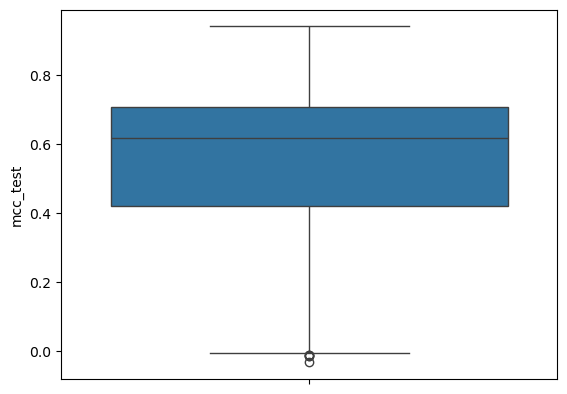

In [28]:
sns.boxplot(data=df_metrics, y="mcc_test");